# DeepFalcon Task 2: top quark autoencoder



I'll start by importing all the libraries I'm going to use and setting random seeds for reproducible results:

In [1]:
import pyarrow.parquet as pq
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

And defining some environment variables such as the path to the dataset:

In [2]:
JETS_DIR = '../input/gsoc-2022-eval/Boosted_Jets_Samples'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_WORKERS = 2

## The data

### Exploring the data

We can initially check out some of the data that we have available, loading one of the parquet datasets:

In [3]:
example = pq.ParquetFile(os.path.join(JETS_DIR, 'Boosted_Jets_Sample-0.snappy.parquet'))
num_rows = example.num_row_groups
example.metadata

  created_by: parquet-cpp version 1.5.1-SNAPSHOT
  num_columns: 1
  num_rows: 32000
  num_row_groups: 32000
  format_version: 1.0
  serialized_size: 4164717

In [4]:
example.schema

required group field_id=-1 schema {
  optional group field_id=-1 X_jets (List) {
    repeated group field_id=-1 list {
      optional group field_id=-1 item (List) {
        repeated group field_id=-1 list {
          optional group field_id=-1 item (List) {
            repeated group field_id=-1 list {
              optional double field_id=-1 item;
            }
          }
        }
      }
    }
  }
}

We have only 1 column over here, composed of a list of lists. The task asks us to perform regression though, which would mean we need a target...

Let's check the data out a bit better by using the same data loading pipeline designed by [Ali Hariri on last year's GSoC](https://github.com/ML4SCI/DeepFalcon/tree/main/GNN_for_Fast_Detector_Simulation_Ali_Hariri).

In [5]:
example_row = example.read_row_group(0)
example_dict = example_row.to_pydict()
example_dict.keys()

dict_keys(['X_jets'])

Indeed we only have one column. Exploring the dataset we can see that the elements in this one column are 3x125x125 images:

(3, 125, 125)


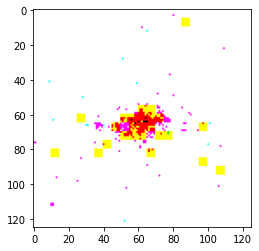

In [6]:
example_data = np.float32(example_dict['X_jets'][0])
print(example_data.shape)
plt.imshow(np.where(example_data.transpose(1,2,0), 0, 255))

Visualization is important in this task, so I'm going to be changing black pixels to white pixels just to make it easier for us to see the changes in the data when we plot it.

Based on last year's GSoC code, [Graph Generative Models for Fast Detector Simulations in Particle Physics paper](https://ml4physicalsciences.github.io/2020/files/NeurIPS_ML4PS_2020_138.pdf) and [End-to-End Physics Event Classification with CMS Open Data](https://arxiv.org/abs/1807.11916), we have that each channel of the image represent a different detector stage:

0. Tracker: constructed as a 2D histogram of the track reconstructed position at perigee in ECAL or HCAL geometry.
1. ECAL: reconstructed hit energies and ECAL crystal coordinates.
2. HCAL: reconstructed hit energies versus HCAL tower coordinates.

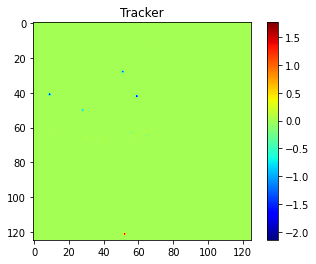

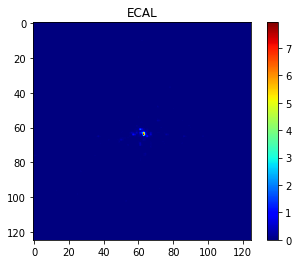

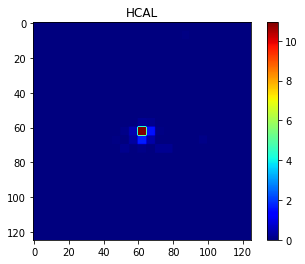

In [7]:
plt.imshow(example_data[0], cmap='jet')
plt.title('Tracker')
plt.colorbar()
plt.show()

plt.imshow(example_data[1], cmap='jet')
plt.title('ECAL')
plt.colorbar()
plt.show()

plt.imshow(example_data[2], cmap='jet')
plt.title('HCAL')
plt.colorbar()
plt.show()

### Dataset and dataloaders

It is also helpful to create custom PyTorch dataloaders in order to load the data more efficiently during training, without the need of loading it all at once on memory (which is not computationally feasible with my resources).

After trying lots of different methods with PyArrow and Dask to read partitioned parquet files efficiently, I wasn't able to come up with a clean way of doing so. Thus I made a hacky method that opens the next file if we've reached the end of the current file:

In [8]:
class JetDataset(Dataset):
    def __init__(self, parquet_files, transform=None, data_col=['X_jets']):
        self.parquets = []
        
        # open each parquet file and count the number of rows
        cumrows = 0
        for f in parquet_files:
            parquet = pq.ParquetFile(f)
            rows = parquet.num_row_groups
            cumrows += rows
            self.parquets.append((parquet, rows, cumrows))
            
        self.transform = transform
        self.data_col = data_col
        
    def __len__(self):
        return sum([i[1] for i in self.parquets])
    
    def __getitem__(self, idx):
        # check in which parquet file the `idx` is in and use that file to load data
        for parquet, rows, cumrows in self.parquets:
            if idx < cumrows:
                break
            else:
                continue
                
        # read data
        idx = idx - (cumrows - rows)
        row = parquet.read_row_group(idx, columns=self.data_col).to_pydict()
        data = np.float32(row['X_jets'][0])
        
        # zero suppression
        data[data < 1.e-3] = 0.
        
        # apply transforms to the data (we're already turning the data to a PyTorch tensor)
        if self.transform:
            data = self.transform(torch.from_numpy(data))
            
        return data

### Splitting train/val/test

We have a HUGE dataset and, as can be seen in my answer to the common task 1 (jet Pt regression), using the whole dataset takes a long time to train. While using Kaggle I gotta be wary of the training time due to notebook runtime restritions, which means that, if I were to use the entire dataset, I'd need to train for fewer epochs. This causes the model to have a subpar performance.

As such, in this task I'm going to be using just a part of the dataset. While the model will have less data to be trained on, at least we'll be able to train it for longer!

I'm only going to be using data augmentation in the dataset, since I believe more information regarding the origins of the data would be needed to apply other pre-processing or data augmentation techniques.

In [9]:
parquet_files = [os.path.join(JETS_DIR, 'Boosted_Jets_Sample-0.snappy.parquet')]

aug = transforms.Compose([transforms.RandomHorizontalFlip(),
                          transforms.RandomVerticalFlip()])

train_dataset = JetDataset(parquet_files, aug)
val_dataset = JetDataset(parquet_files)
test_dataset = JetDataset(parquet_files)

In [10]:
len(train_dataset) # == len(val_dataset) == len(test_dataset)

32000

We went from 160000 images to 32000... quite the difference!

Since we'lll be using less data on this task, we're going to use a 80/10/10 split:

In [11]:
train_size = 0.8

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

In [12]:
print('train dataset size:', len(train_data), 'percentage of train dataset:', len(train_data) / len(train_dataset))
print('val dataset size:', len(val_data), 'percentage of val dataset:', len(val_data) / len(train_dataset))
print('test dataset size:', len(test_data), 'percentage of test dataset:', len(test_data) / len(train_dataset))

train dataset size: 25600 percentage of train dataset: 0.8
val dataset size: 3200 percentage of val dataset: 0.1
test dataset size: 3200 percentage of test dataset: 0.1


We can now create the dataloaders that will be used for training, validation and testing:

In [13]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

## Scaling the data

Autoencoders work better when we scale our data to a range between [-1,1] or [0,1], so I'm going to iterate over the data we have in order to get the minimum and maximum values of the dataset. Since each channel in our data is from a different detector, I'm going to be considering the minimum and maximum values of each channel (tracker, ECAL, HCAL) separately.

In [14]:
"""
mins = {'tracker': [], 'ecal': [], 'hcal': []}
maxs = {'tracker': [], 'ecal': [], 'hcal': []}

for data in train_dataloader:
    tracker = data[:, 0]
    ecal = data[:, 1]
    hcal = data[:, 2]
    
    mins['tracker'].append(tracker.min())
    mins['ecal'].append(ecal.min())
    mins['hcal'].append(hcal.min())
    
    maxs['tracker'].append(tracker.max())
    maxs['ecal'].append(ecal.max())
    maxs['hcal'].append(hcal.max())

# (min, max)
tracker_scaler = (min(mins['tracker']), max(maxs['tracker']))
ecal_scaler = (min(mins['ecal']), max(maxs['ecal']))
hcal_scaler = (min(mins['hcal']), max(maxs['hcal']))
"""

# this code takes a while to run, so i'm hard coding the results
tracker_scaler = (0.0, 2.4999)
ecal_scaler = (0.0, 153.6213)
hcal_scaler = (0.0, 30.9880)

# organizing by channel
data_scale = {0: tracker_scaler, 1: ecal_scaler, 2: hcal_scaler}
data_scale

{0: (0.0, 2.4999), 1: (0.0, 153.6213), 2: (0.0, 30.988)}

This allows us to rescale the data into one of these ranges using:

$x_{std} = \frac{x - x_{min}}{x_{max} - x_{min}} \rightarrow x_{scaled} = x_{std} \cdot (n_{max} - n_{min}) + n_{min}$

Where $n_{min}$ represents the new minimum value and $n_{max}$ represents the new maximum value. In our case, we'll set it to $n_{min} = 0$ and $n_{max} = 1$.

In [15]:
def min_max_scaler(data, data_scale, new_scale=(0,1)):
    new_min, new_max = new_scale
    data = data.clone()
    
    # iterate through each channel, scaling according to its (min, max)
    for channel in data_scale:
        data_min, data_max = data_scale[channel]

        channel_data = data[:, channel]

        data_std = (channel_data - data_min) / (data_max - data_min)
        data_scaled = data_std * (new_max - new_min) + new_min

        data[:, channel] = data_scaled
    
    return data

I'm going to be using it during the training and evaluation loop whenever we're load in new data. This could be made into a transform to be used when creating our dataset but due to the way I'm currently splitting the data (after creating a dataset) I'd need to colect the minimum and maximum value statistics on all data. This would cause a ton of *data leakage*, since the values we get would also be computed using the val and test data.

## Creating the autoencoder

Autoencoders are models that encode an input data to a smaller feature vector and, afterwards, reconstruct it. To encode the data to a feature vector we use an **encoder** and to reconstruct the data from the feature vector we use a **decoder**.

### Arquitecture

I'm going to be using a convolutional variational autoencoder (VAE). VAEs are especially interesting due to the fact their encodings distribution is regularised during the training in order to ensure that its latent space has good properties. This allows us to generate new data by interpolating between values on the feature vector latent space. I'm going to be encoding the images to a feature vector of size 1000.

I'm also going to be making the VAE receive as input an 1 channel image. This is because we want to reconstruct Tracker, ECAL and HCAL images, and each are a channel in our data. So this way we can basically consider that each of the channels is a different class

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.mu = nn.Linear(3136, 512)
        self.var = nn.Linear(3136, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        mu = self.mu(x)
        var = self.var(x)

        return mu, var

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(512, 3136)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=1)

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(-1, 64, 7, 7)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x)) # input scaled between 0 and 1, so output has to be bounded as well

        return x
    
class VAE(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        
        mu, var = self.encoder(x)
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(mu)
        x = self.decoder(x_sample)
        
        return x, mu, var

### Training and evaluation loops

I'll first define a function that enables us to see how the autoencoder learns to reconstruct our data as it is being trained (`vmin` and `vmax` are hard-coded based on the values that I found to output good visualizations; notice that the data received by the function is already scaled between 0 and 1):

In [17]:
def display_images(input_image, output_image, display=1):
    titles = ['Tracker', 'ECAL', 'HCAL']
    
    for d in range(display):
        # plot input images
        input_image_numpy = input_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))
        plt.suptitle('Original images // Reconstructed images', fontsize=20)

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(input_image_numpy[i+4*d][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)

        plt.show()
                
        # plot output images
        output_image_numpy = output_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(output_image_numpy[i+4*d][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)
            
        plt.show()

We'll also define the loss function we'll be using, that'll be computed based on the reconstruction loss and the KL divergence:

In [18]:
def vae_loss(pred, true, mu, var):
    rec = F.binary_cross_entropy(pred, true, reduction='sum') # reconstruction
    #rec = F.mse_loss(pred, true, reduction='sum') # reconstruction
    kl = -0.5 * torch.mean(1 + var - mu.pow(2) - var.exp()) # KL

    return rec + kl

Now all we need is to define how our model will be trained and evaluated. For demonstration purposes I'm going to make the hyperparameters fixed. I'll also be using the validation dataset for early stopping if the training loss stops decreasing.

In [19]:
def evaluate(model, dataloader, data_scale, display=0):
    # set network to evaluation mode
    model.eval()
    
    criterion = vae_loss
    running_loss = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            data = data.to(DEVICE)
            data = min_max_scaler(data, data_scale)
            
            if display:
                outputs_list = [] # used for displaying reconstructed images
            
            for channel in data_scale:
                # unsqueeze to generate 1 channel axis
                data_channel = data[:, channel].unsqueeze(1)
            
                # predict
                outputs, mu, var = model(data_channel)
                running_loss += criterion(outputs, data_channel, mu, var).item()
                
                if display:
                    outputs_list.append(outputs)
            
        # get loss over whole dataset
        loss = running_loss / len(dataloader)
        
        # display images
        if display:
            # concatenate Tracker, ECAL, HCAL images
            outputs_list = torch.cat(outputs_list, dim=1)
            display_images(data, outputs_list, display)
            
    return loss
    

def train(model, train_dataloader, val_dataloader, data_scale, epochs):
    # hyperparameters and optimizer
    criterion = vae_loss
    lr = 1e-3
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # early stopping variables
    best_loss = np.inf # ideal loss == 0
    patience = 5 # stops training if loss doesn't improve in 5 epochs
    bad_epochs = 0
    
    # metrics
    history = {'train_loss': [], 'val_loss': []}
    
    # train
    for epoch in range(epochs):
        # set network to training mode
        encoder.train()
        decoder.train()

        running_loss = 0.0

        for data in train_dataloader:
            data = data.to(DEVICE)
            data = min_max_scaler(data, data_scale)
            
            outputs_list = [] # used for displaying reconstructed images

            # we'll be iterating over each channel in order to update the VAE weights
            # for each Tracker, ECAL, HCAL image inside `data`
            for channel in data_scale:
                # unsqueeze to generate 1 channel axis
                data_channel = data[:, channel].unsqueeze(1)
                
                # zero gradients
                optimizer.zero_grad()

                # encode/decode ang get loss
                outputs, mu, var = model(data_channel)
                loss = criterion(outputs, data_channel, mu, var)

                # backpropagate and update weights
                loss.backward()
                optimizer.step()

                # metrics
                running_loss += loss.item()
                
                outputs_list.append(outputs)

        # get metrics
        epoch_loss = running_loss / len(train_dataloader)
        history['train_loss'].append(epoch_loss)
        
        # lr scheduler
        scheduler.step()
        
        # display reconstruction for training data
        outputs_list = torch.cat(outputs_list, dim=1) # concatenate Tracker, ECAL, HCAL images
        display_images(data, outputs_list)

        # evaluate on validation data
        val_epoch_loss = evaluate(model, val_dataloader, data_scale)
        history['val_loss'].append(val_epoch_loss)

        print('[Epoch {}/{}] loss: {:.6f}; val loss: {:.6f};'.format(epoch+1, epochs, epoch_loss, val_epoch_loss))
        
        # save checkpoint
        if val_epoch_loss < best_loss:
            torch.save({'encoder_weights': encoder.state_dict(),
                        'decoder_weights': decoder.state_dict()}, './model_task2.pt')
            best_loss = val_epoch_loss
            bad_epochs = 0

        else:
            bad_epochs += 1

        if bad_epochs >= patience:
            print(f"reached {bad_epochs} bad epochs, stopping training with best val loss of {best_loss}!")
            break

    best = torch.load('./model_task2.pt')
    encoder.load_state_dict(best['encoder_weights'])
    decoder.load_state_dict(best['decoder_weights'])

    return encoder, decoder, history

## Training the model

Now we just need to train our regression model!

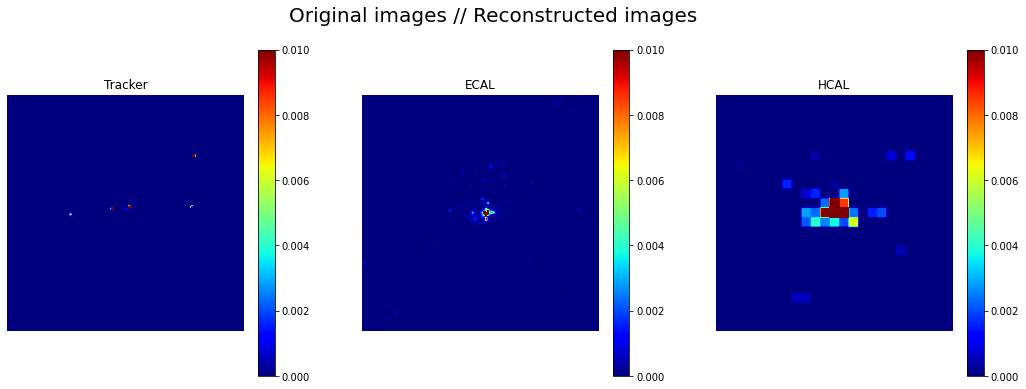

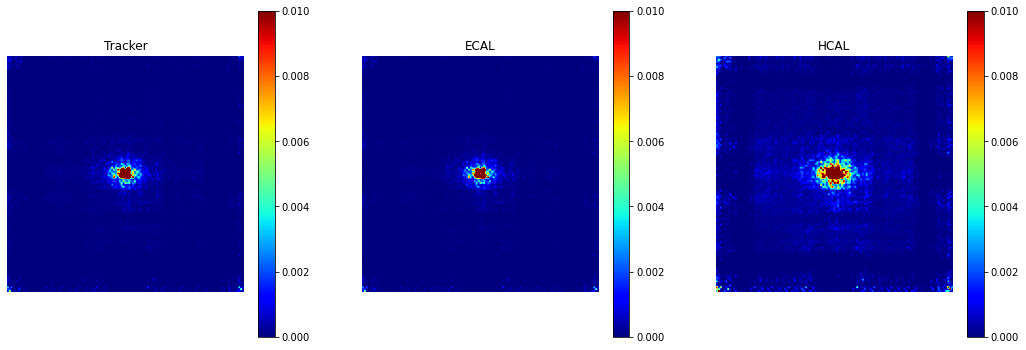

[Epoch 1/20] loss: 66156.137784; val loss: 5141.836901;


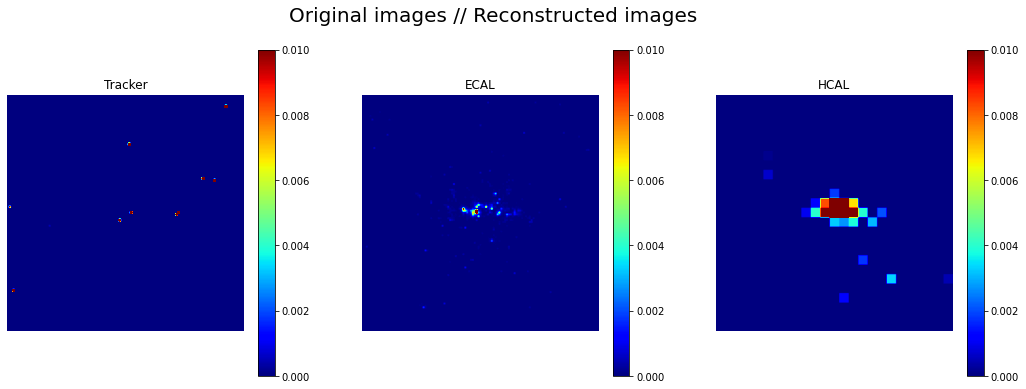

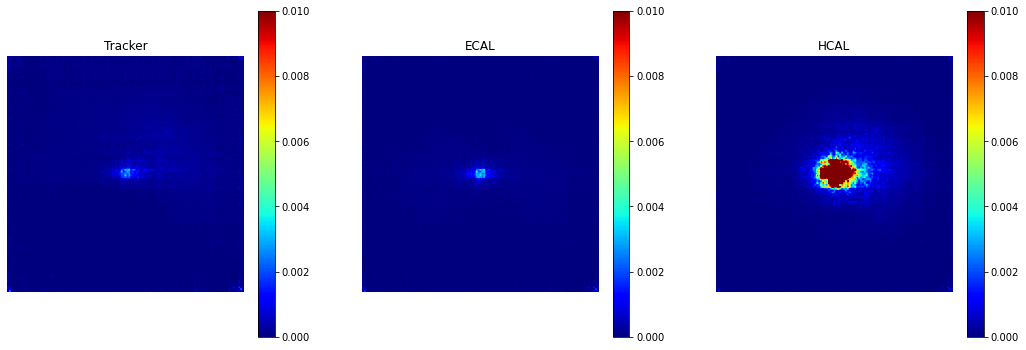

[Epoch 2/20] loss: 4704.963398; val loss: 4435.837084;


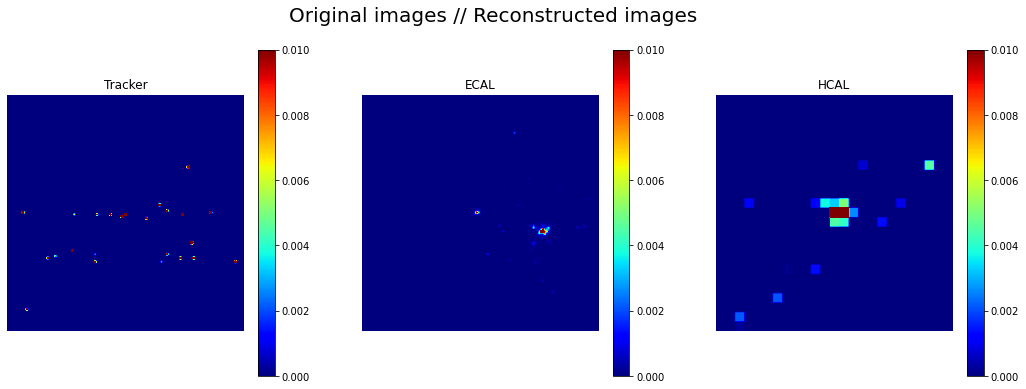

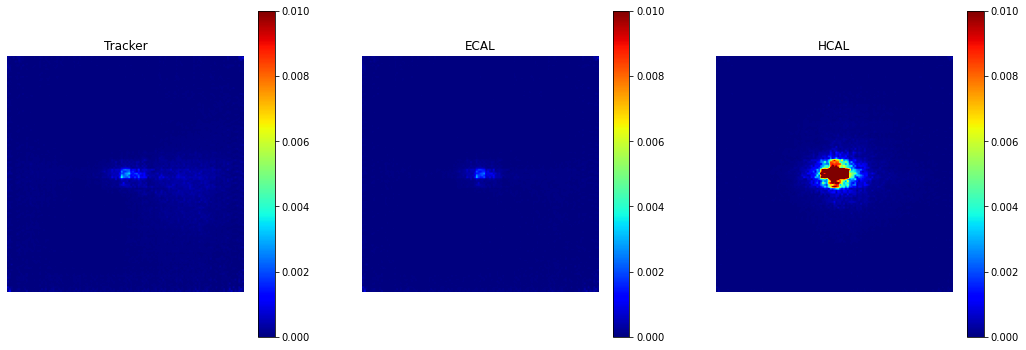

[Epoch 3/20] loss: 4473.534106; val loss: 4320.571820;


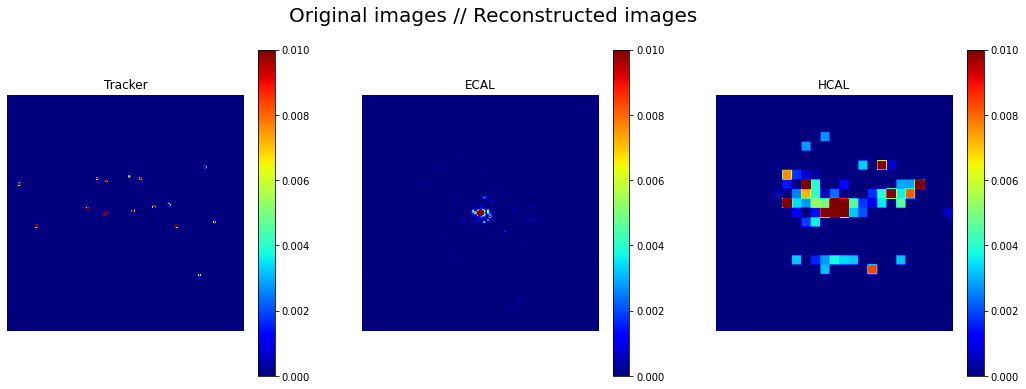

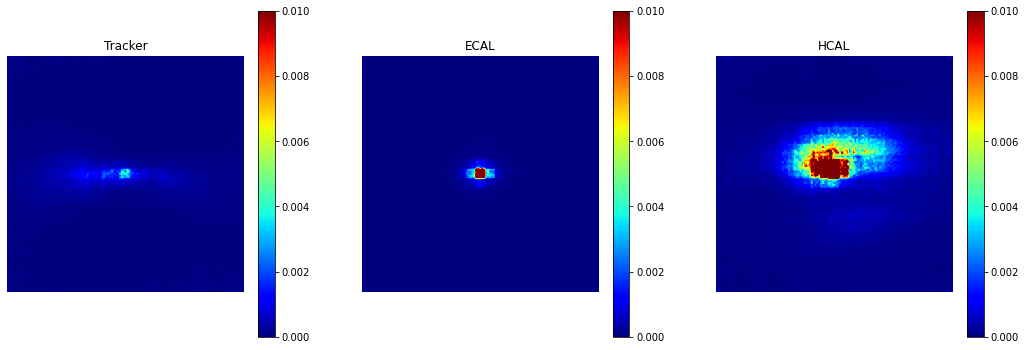

[Epoch 4/20] loss: 4281.587038; val loss: 4207.559642;


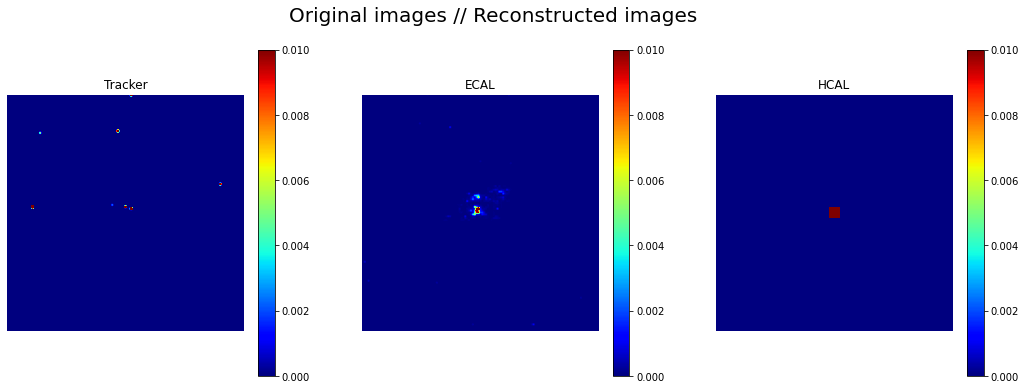

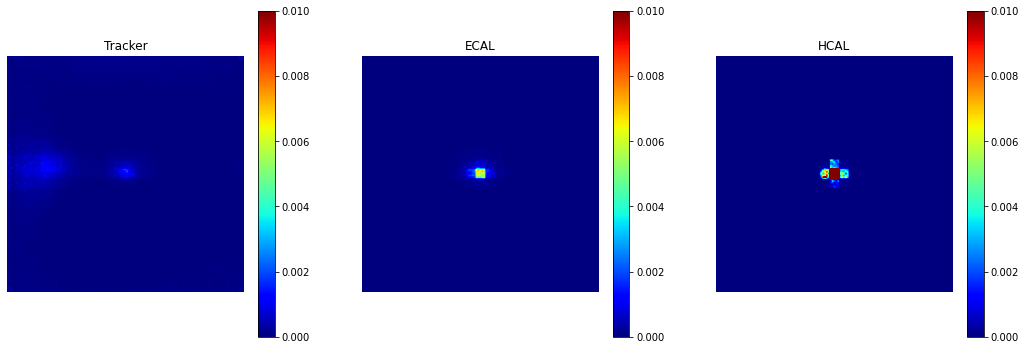

[Epoch 5/20] loss: 4159.556748; val loss: 4012.617528;


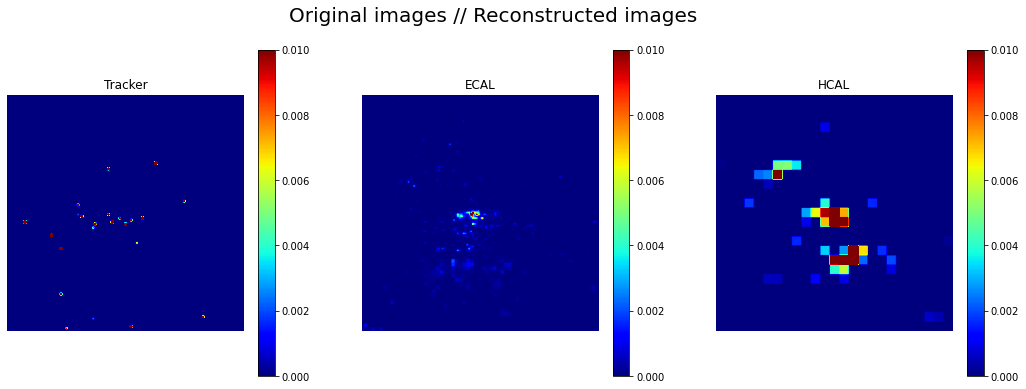

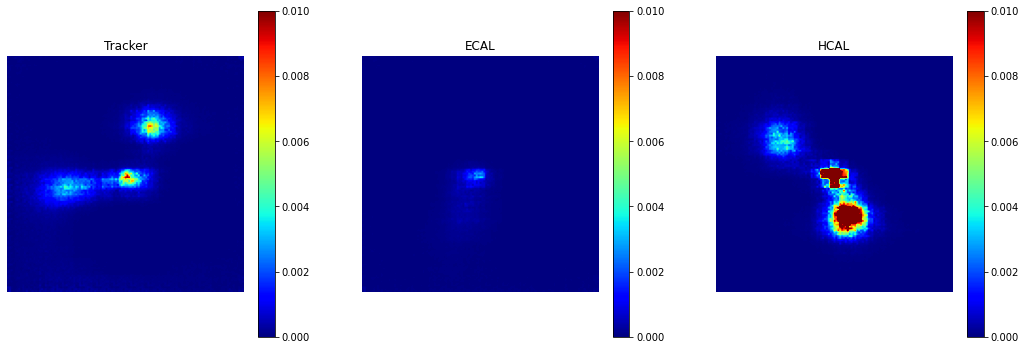

[Epoch 6/20] loss: 4003.589350; val loss: 3980.209804;


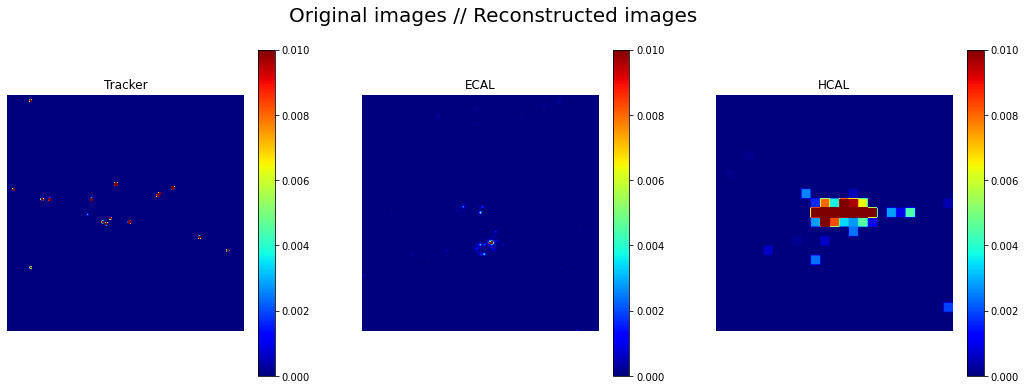

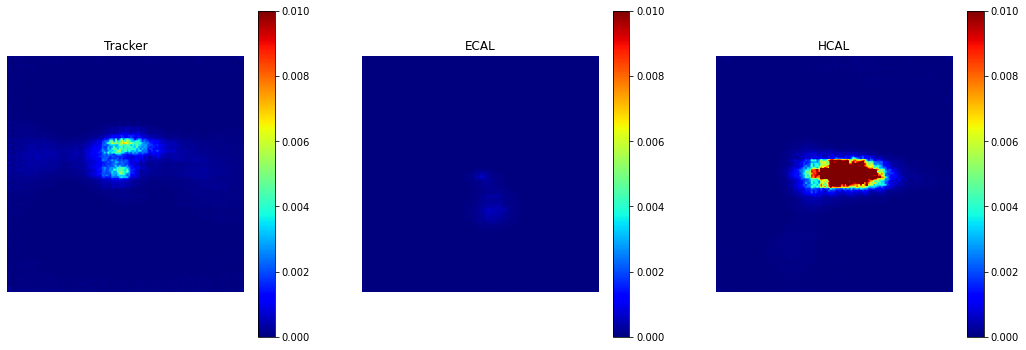

[Epoch 7/20] loss: 3977.973734; val loss: 3953.500583;


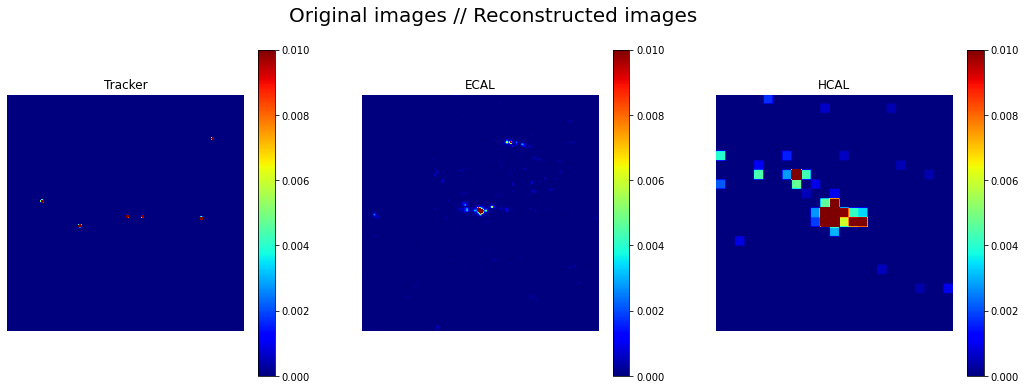

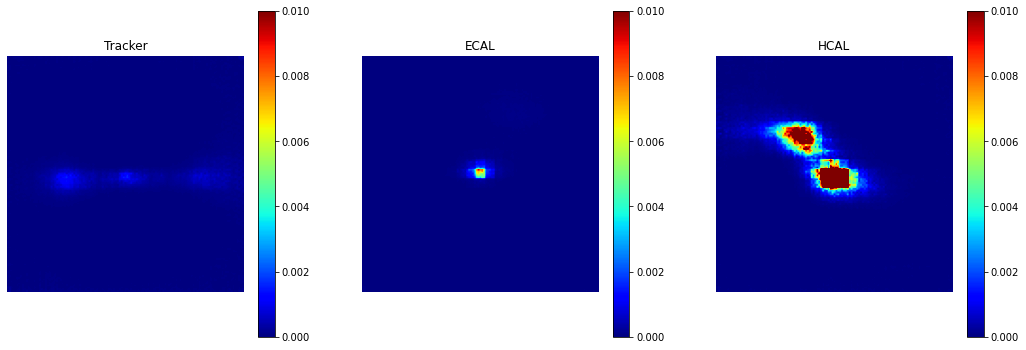

[Epoch 8/20] loss: 3947.683859; val loss: 3919.598725;


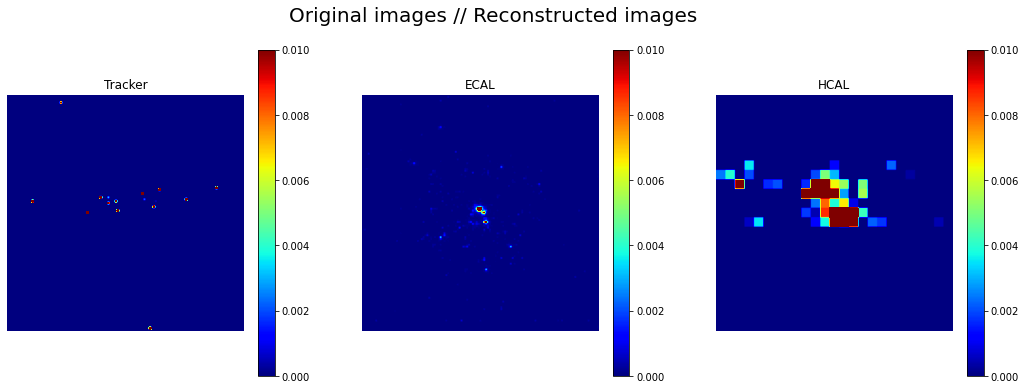

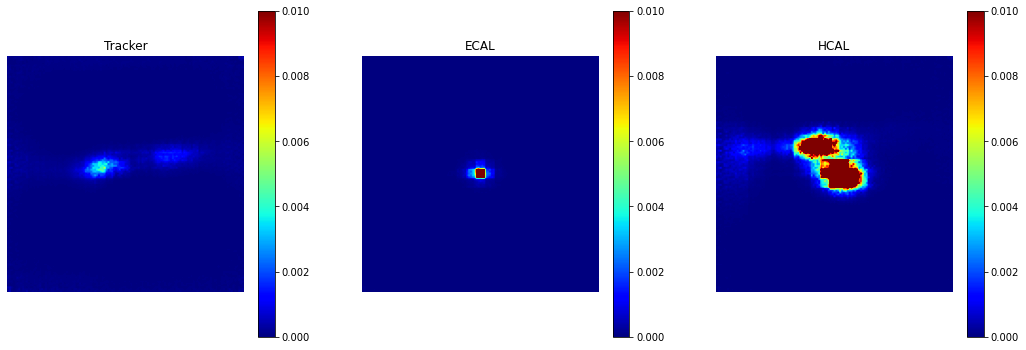

[Epoch 9/20] loss: 3911.569948; val loss: 3879.848472;


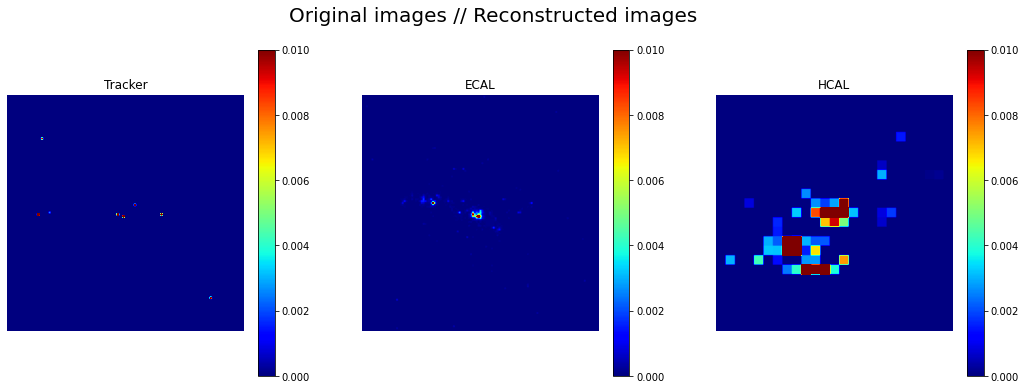

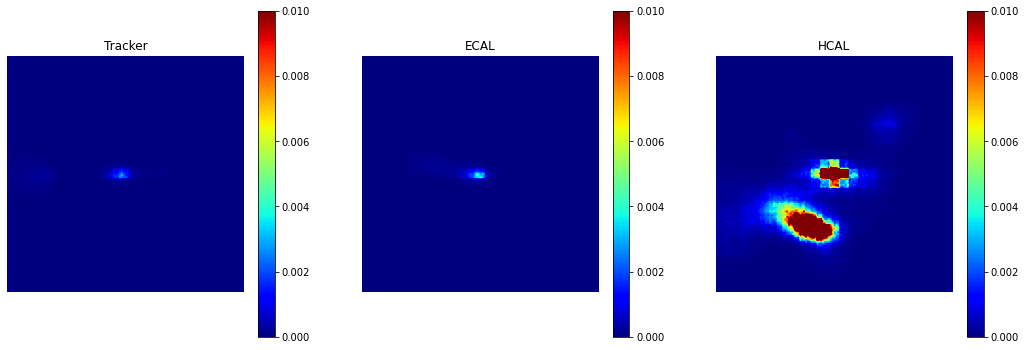

[Epoch 10/20] loss: 3871.207034; val loss: 3839.277663;


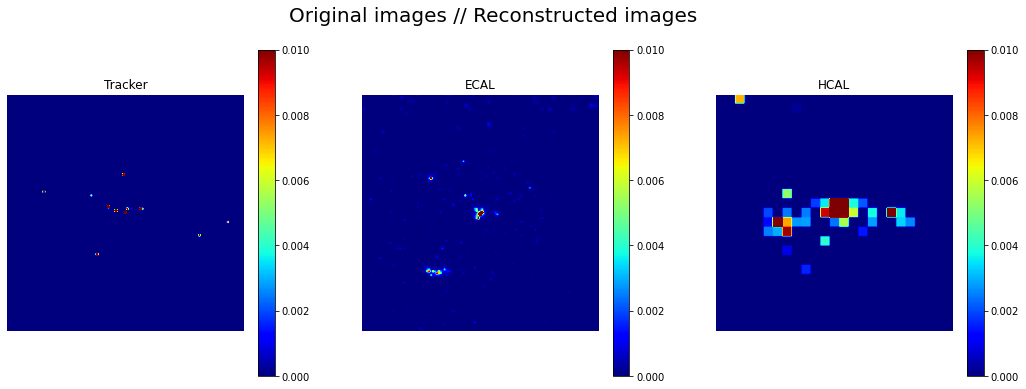

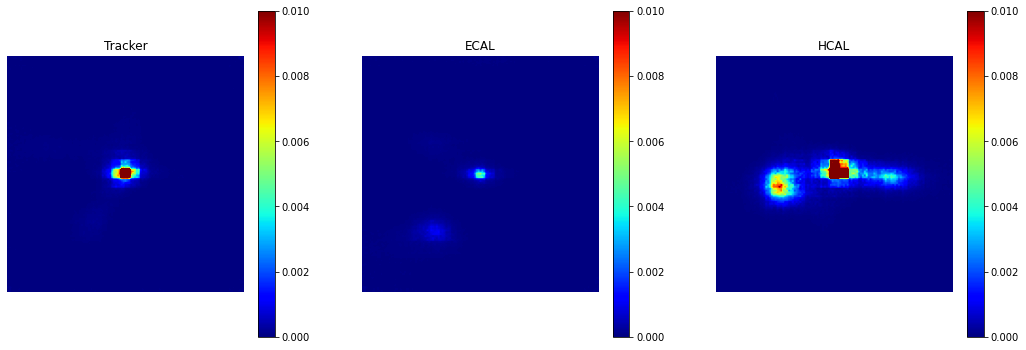

[Epoch 11/20] loss: 3844.702120; val loss: 3831.444144;


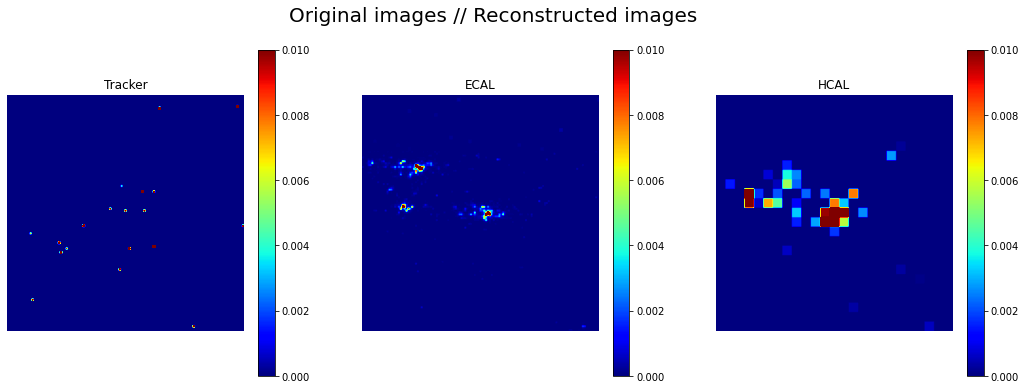

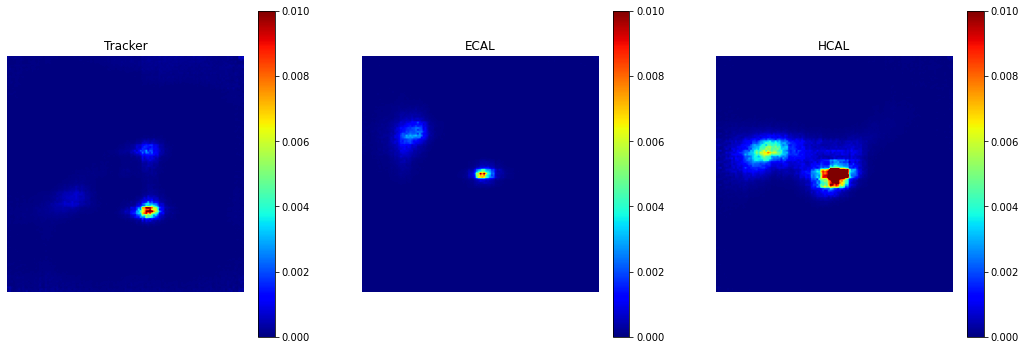

[Epoch 12/20] loss: 3839.349382; val loss: 3826.542950;


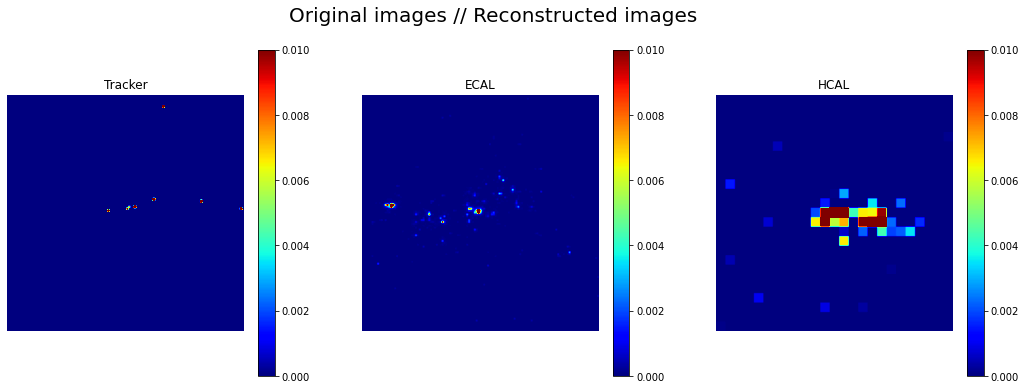

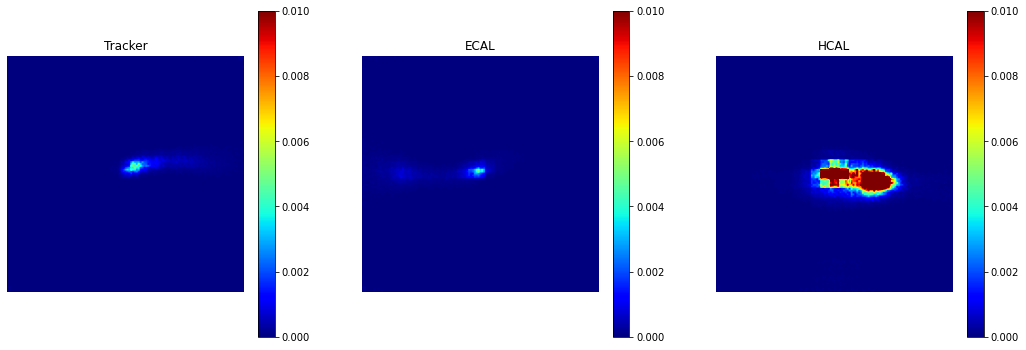

[Epoch 13/20] loss: 3834.535891; val loss: 3821.790492;


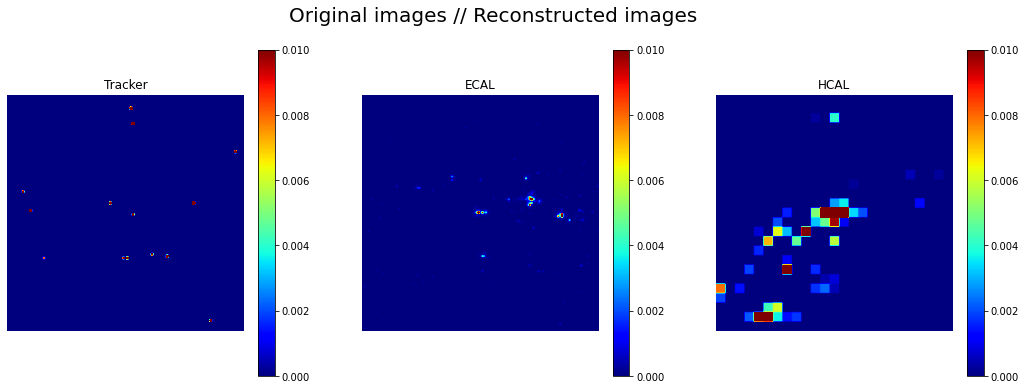

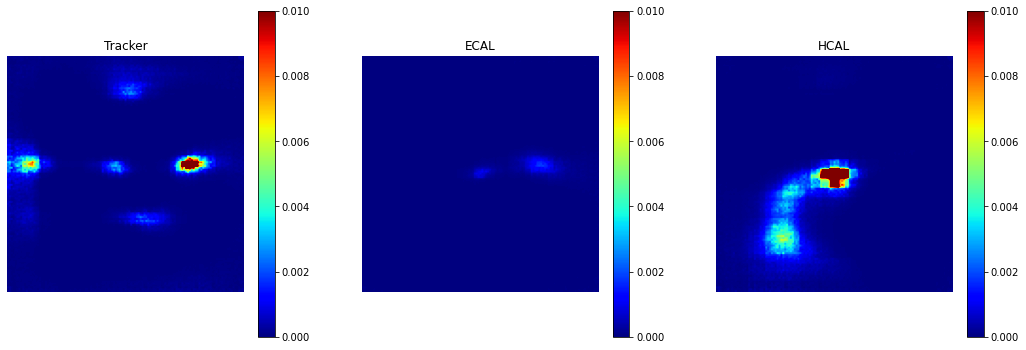

[Epoch 14/20] loss: 3829.586735; val loss: 3816.758445;


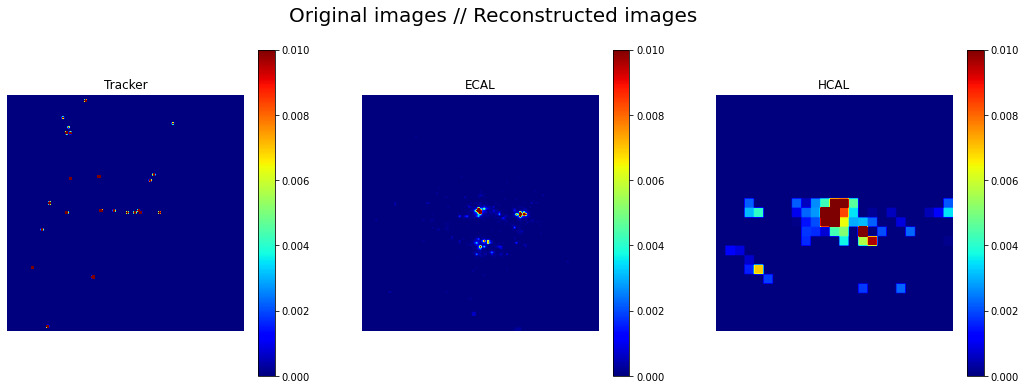

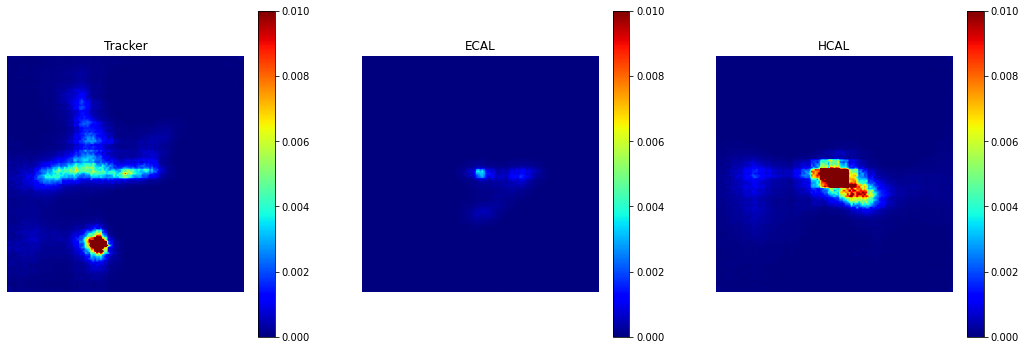

[Epoch 15/20] loss: 3824.885999; val loss: 3811.648810;


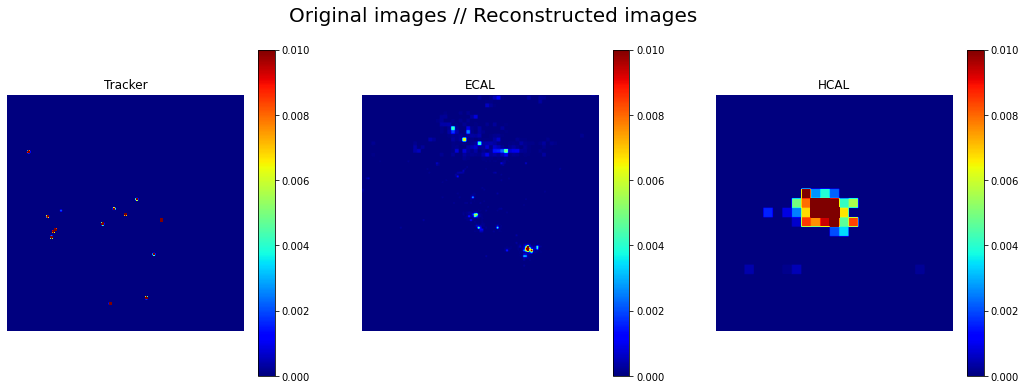

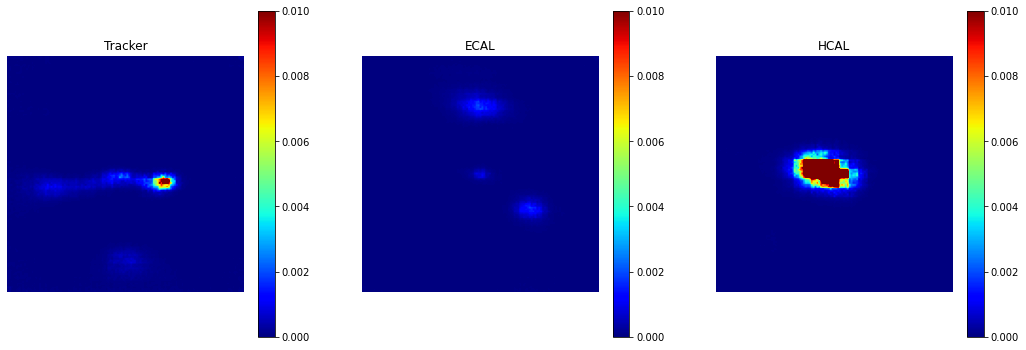

[Epoch 16/20] loss: 3821.586943; val loss: 3810.839835;


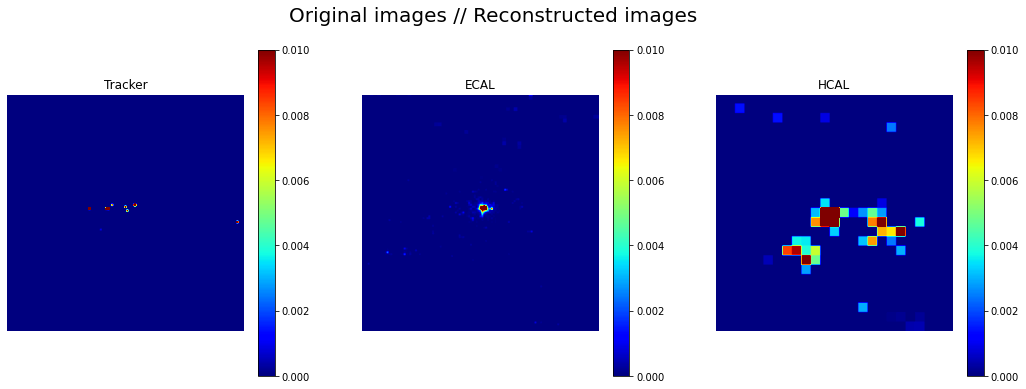

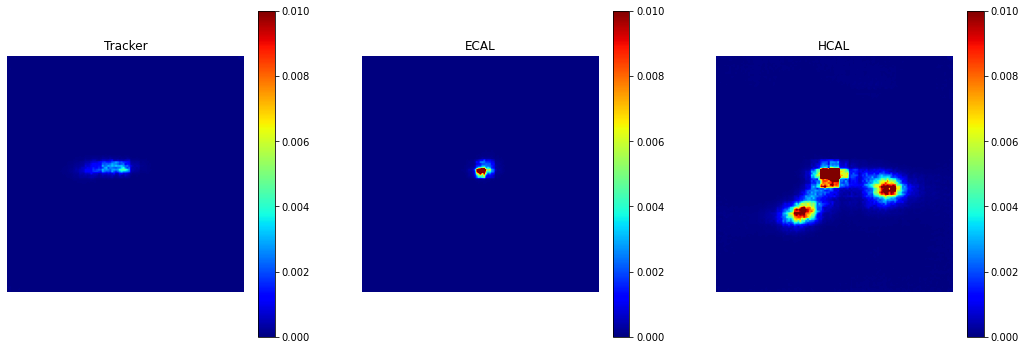

[Epoch 17/20] loss: 3821.110499; val loss: 3810.162360;


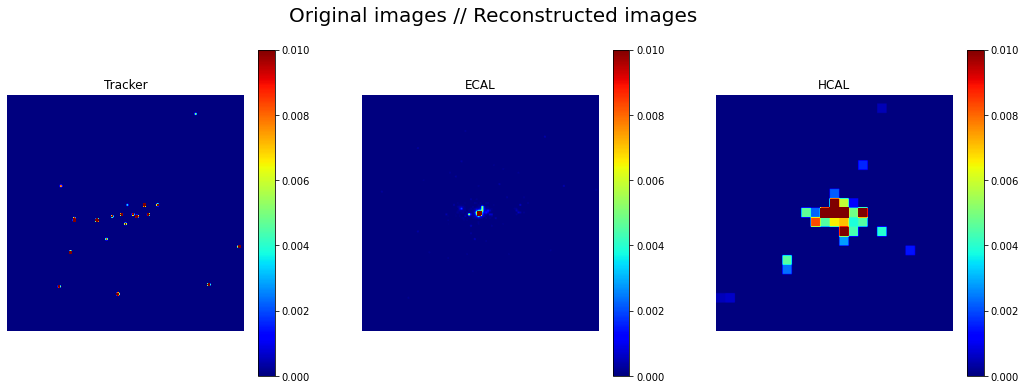

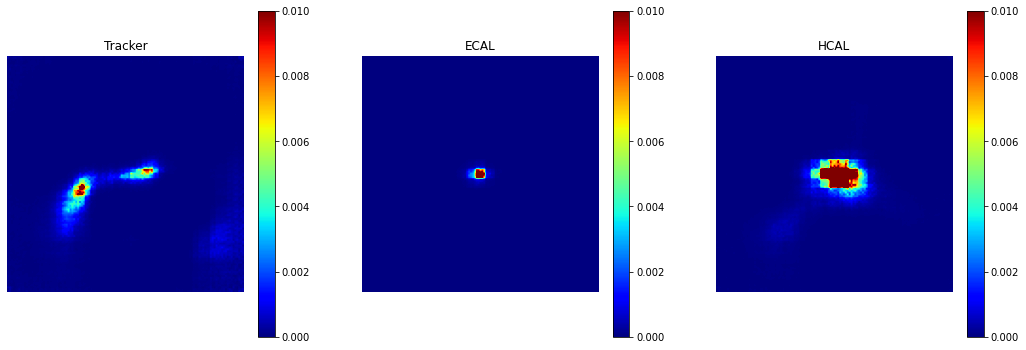

[Epoch 18/20] loss: 3820.401478; val loss: 3809.881382;


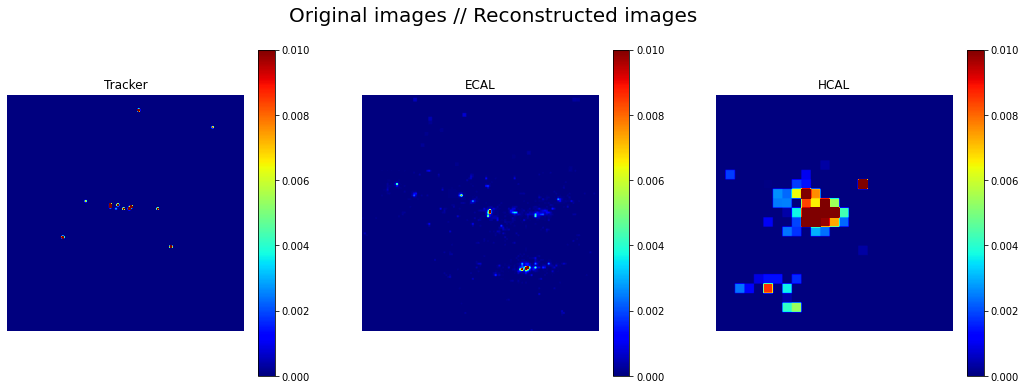

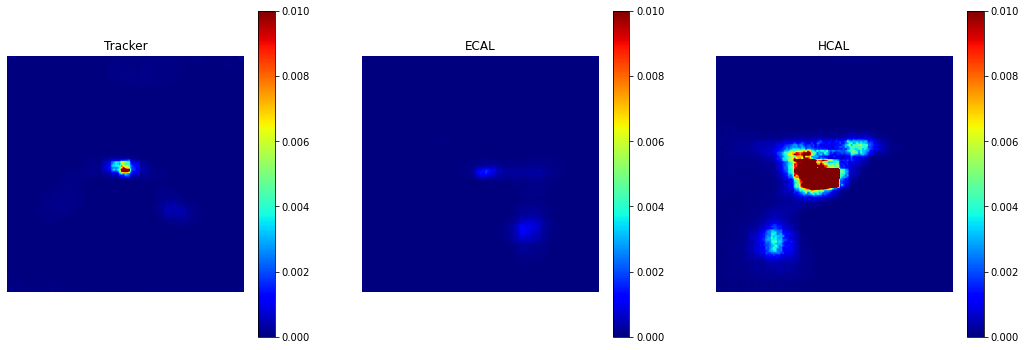

[Epoch 19/20] loss: 3820.104118; val loss: 3809.223477;


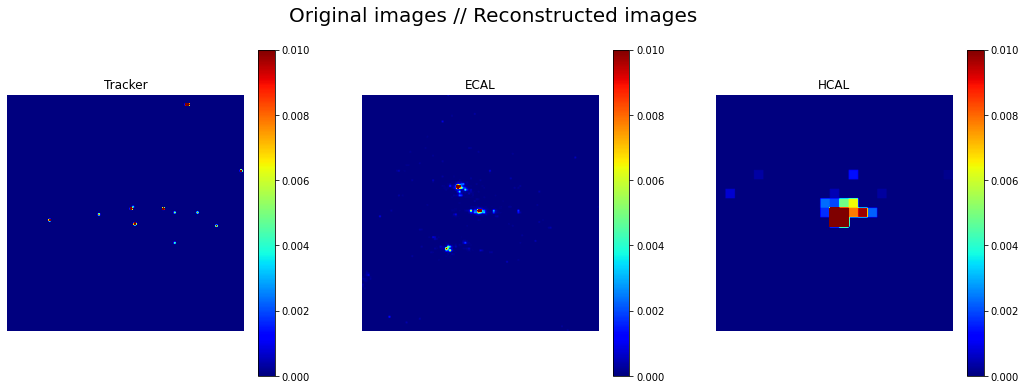

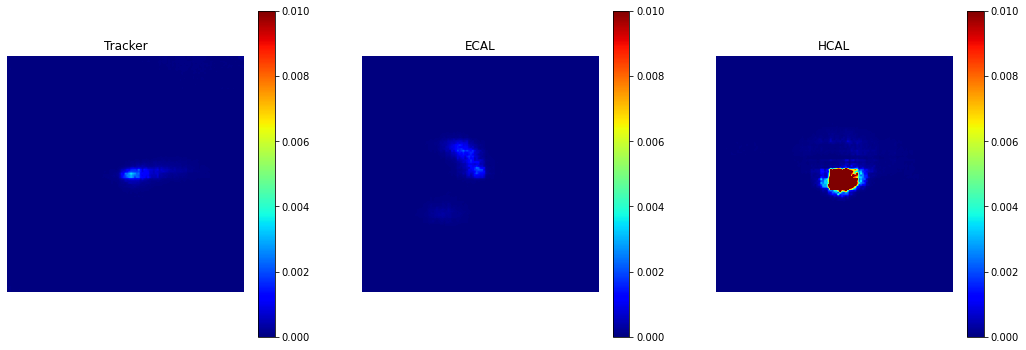

[Epoch 20/20] loss: 3819.283307; val loss: 3808.749029;


In [20]:
encoder = Encoder()
encoder = encoder.to(DEVICE)

decoder = Decoder()
decoder = decoder.to(DEVICE)

vae = VAE(encoder, decoder)
vae = vae.to(DEVICE)

encoder, decoder, history = train(vae, train_dataloader, val_dataloader, data_scale, epochs=20)

We can also look at the training metrics in order to see how it evolves over time:

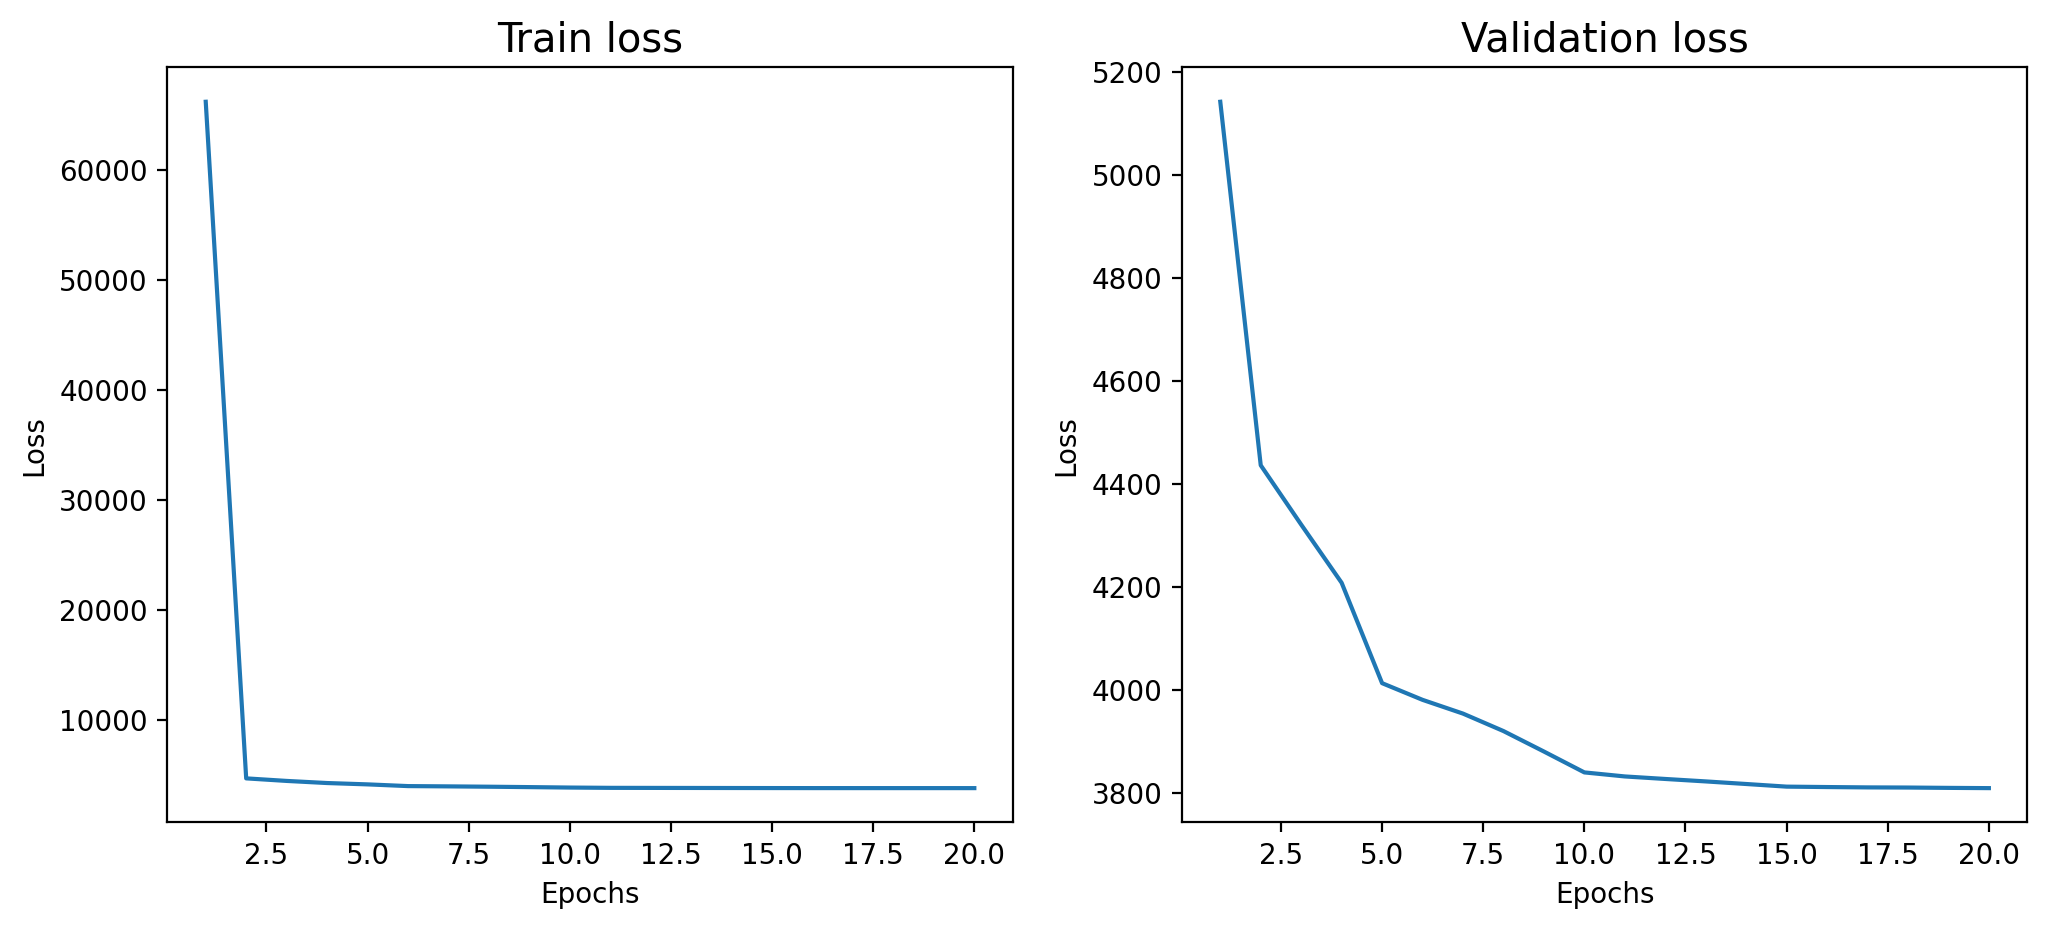

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=200)

plt.style.use('ggplot')

epochs = len(history['train_loss'])

axs[0].plot(range(1, epochs+1), history['train_loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train loss')

axs[1].plot(range(1, epochs+1), history['val_loss'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Validation loss')

plt.show()

## Evaluating the model

The loss of the model on the test set and some reconstructions of the test set are given by:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  from ipykernel import kernelapp as app


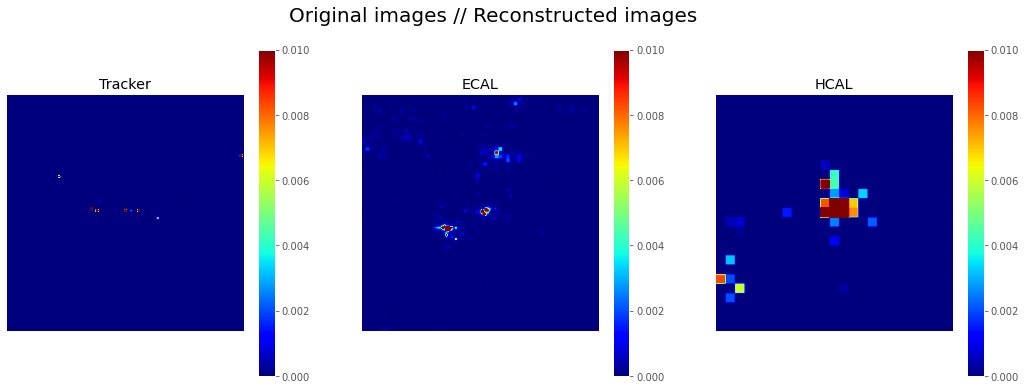

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


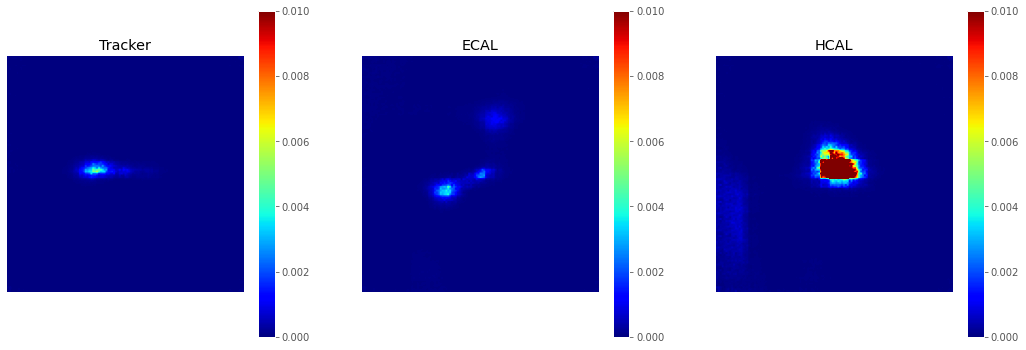

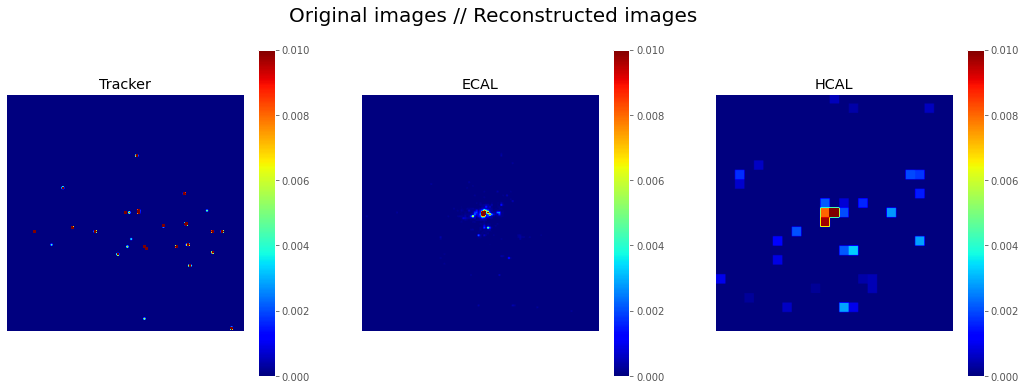

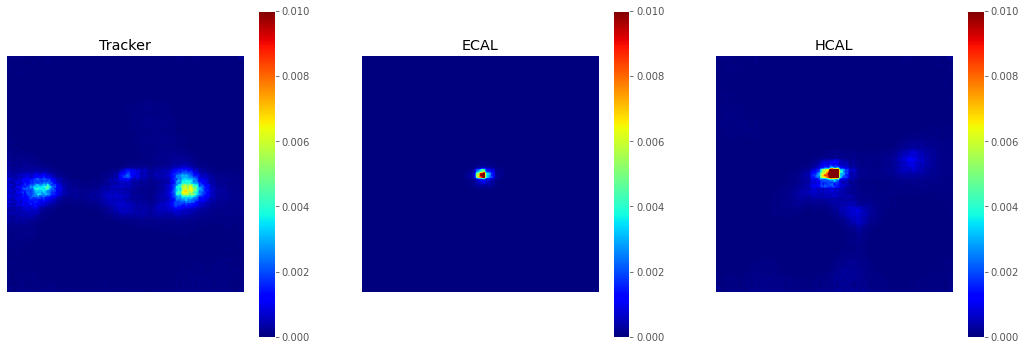

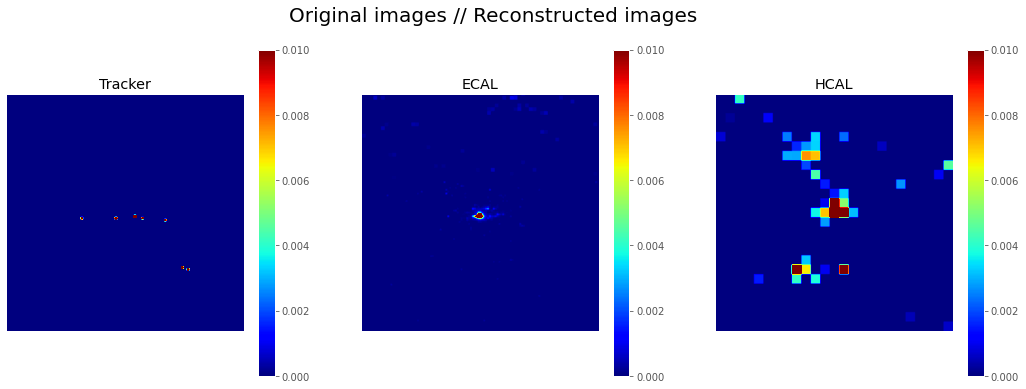

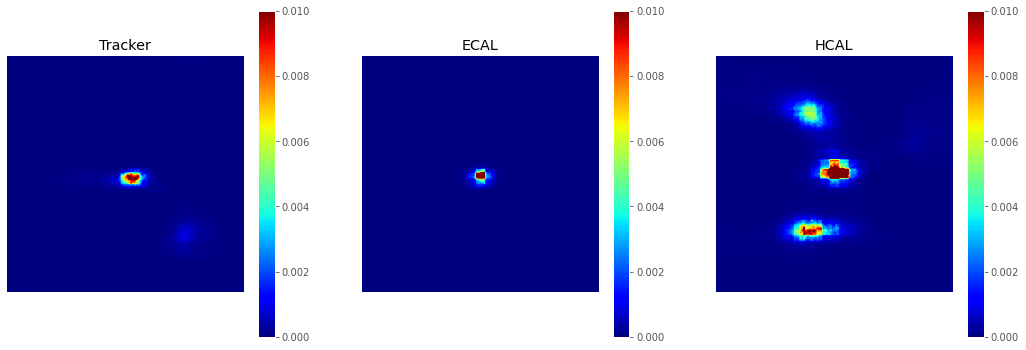

LOSS ON TEST SET: 3825.5957373046876


In [22]:
test_loss = evaluate(vae, test_dataloader, data_scale, display=3)
print('LOSS ON TEST SET:', test_loss)

## Conclusion

We can see that the autoencoder somewhat learns to reconstruct the ECAL, HCAL and Tracker images. The reconstructions are kinda blurry and the VAE appears to have some problems differentiating between Tracker and ECAL, likely because the encodings in the latent space are close to each other. If I understood the origins of our data correctly, Tracker is based on ECAL and HCAL, so I believe this is to be expected.

Related to the blurry reconstructions I believe there is one main problem: **the architecture is not robust enough**. The data we're dealing with is extremely sparse, having a bunch of zero-values elements in each image. As such, we get a lot of blank space in our image that is probably negatively impacting our loss calculation. I believe an architecture such as a GNN would be able to overcome such problems. Also, autoencoder-based models generally output blurry images, so, were we to keep using convolutional networks, methods like GANs or diffusion models would probably work better.

There are also other things that could improve this model:

- **Preprocess the data**: applying domain-specific preprocessing steps particular to our data could be very helpful to the model.
- **Use the entire dataset**: here I'm just using one of the parquet files that are available, but using all of them would give us significantly more data points, which is highly beneficial.
- **Train for longer**: I trained the model for only 20 epochs in order to not exceed my GPU quota on Kaggle, but training it for longer would benefit the model a lot.
- **Perform a hyperparameter search**: testing different optimizers, loss functions, learning rates and learning rate schedulers would help us squeeze the best performance we can get out of our model.